In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq "./drive/MyDrive/Dataset/classification_aircraft.zip"
!pip install tensorflow-addons

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.6 MB/s eta 0:00:00


## Data Loading

We will begin with loading the dataset and creating train, test and validation sets as per the csv file provided.

In [4]:
## importing dataset
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
val = pd.read_csv("./val.csv")

In [5]:
tpath = "./fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/"
train_paths = train.filename.apply(lambda x: os.path.join(tpath, x))
train_labels = to_categorical(train.Labels)

tpath = "./fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/"
val_paths = val.filename.apply(lambda x: os.path.join(tpath, x))
val_labels = to_categorical(val.Labels)


tpath = "./fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/"
test_paths = test.filename.apply(lambda x: os.path.join(tpath, x))
test_labels = to_categorical(test.Labels)


## Data Preprocessing

First, we will convert the image size to (512,512). We experimented with (64,64) and (128, 128) size images, and they didn't provide decent results. Next, we will also perform some augmentation. Ideally, we should perform rotation, flips, and box cut methods, but for simplicity we will just perform random left right flip operation on the image. We will also convert the train, test and val to tf.data.Dataset format.

In [2]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)

    if label is None:
        return image
    else:
        return image, label

In [3]:
def augment(image, label=None):
    image = tf.image.random_flip_left_right(image)

    if label is None:
        return image
    else:
        return image, label

In [8]:
batch_size = 8

AUTO = tf.data.experimental.AUTOTUNE
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(decode_image, num_parallel_calls=AUTO).map(augment, num_parallel_calls=AUTO).repeat().shuffle(2048)
    .batch(batch_size)
    .prefetch(AUTO)
)

val_dataset = (tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(decode_image, num_parallel_calls=AUTO).batch(batch_size))

test_dataset = (tf.data.Dataset.from_tensor_slices(test_paths).map(decode_image, num_parallel_calls=AUTO).batch(batch_size))

Now, that we have created datasets, let's view a few images and class distribution.

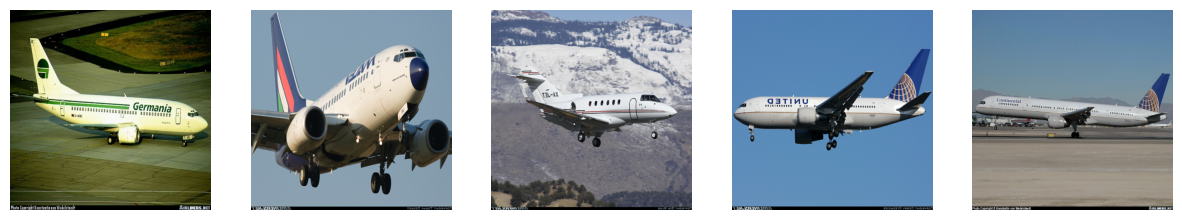

In [9]:
import matplotlib.pyplot as plt

# Function to plot images from the dataset
def plot_images(dataset, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[0])
        # plt.title(f"Label: {label}")
        plt.axis("off")
    plt.show()

# Plot images from the dataset
plot_images(train_dataset)

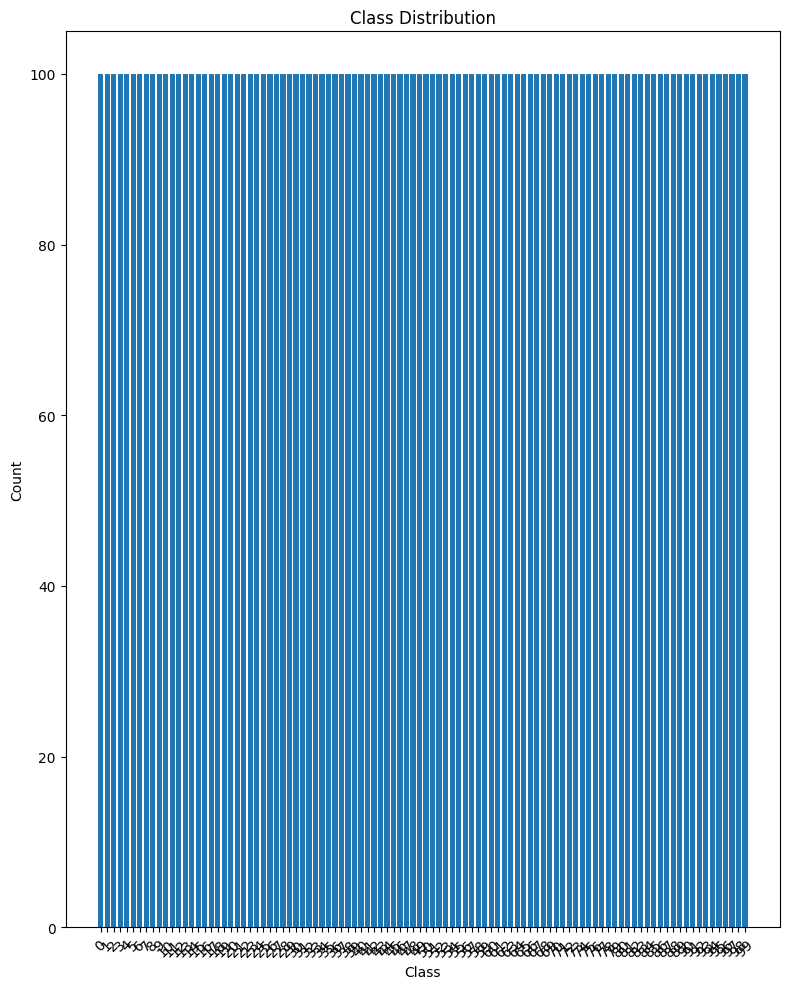

In [10]:
# Plot the distribution of classes
class_distribution = train['Labels'].value_counts() + test['Labels'].value_counts() + val['Labels'].value_counts()
plt.figure(figsize=(8, 10))
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(class_distribution.index, rotation=45)  # Adjust labels based on your actual classes
plt.tight_layout()
plt.show()

All the classes have the same number of images, so we don't have class imbalance. Next, we will move forward with building our model to process these images.

## Model

We will be using EfficientNetB7 for our task. EfficientNet B7 is part of the EfficientNet family of neural network architectures, which were introduced to provide an efficient yet powerful model that performs well across a range of different tasks while being computationally efficient. It has shown quite promising results for image classification tasks and will prove to be a decent base model of our architecture. We also tried different other models as our base models, such as DenseNet201, VGG19, etc, but Efficient showed the most promising results. Next, for our neural network architecture, we will have two Dense layers of 1024 and 512 units. We will also add a Batch Normalization, Activation function and Dropout layer after each of these dense layers. Finally, a Dense layer of 100 units with softmax activation function to get our output. We experimented with many optimizers for the learning process and, AdamW showed the best results.

Finding the optimal learning rate for the optimizer proved to be the trickiest part of the whole process. If the learning rate was too high, the model would jump over the most optimal solution and overfit the training data very quickly, and if the learning rate was quite small, the accuracy would take a hit. Learning rate between 0.00001 and 0.00005 showed the best results. We also experimented with different optimizers such Adam, AdamW, RectifiedAdam, and SGD. AdamW showed the best results on validation set. Let's compile our model and fit it on the training data.


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.applications import DenseNet201, EfficientNetB7

# Load pre-trained ResNet50 model without top (fully connected) layers
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Freeze the layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False

# Create a new model on top of the ResNet base
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation = "relu"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.3))
# model.add(layers.Dense(256, activation = "relu"))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(128, activation = "relu"))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))  # Adjust num_classes based on your dataset

# adam = RectifiedAdam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, weight_decay = 0.015)
adam = AdamW(learning_rate = 0.00003, beta_1 = 0.9, beta_2 = 0.999, weight_decay = 0.015)
# sgd = SGD(learning_rate = 0.0001)
# Compile the model
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Now you can train the model on your airplane dataset
# Use model.fit() with your dataset and labels
model.summary()

c:\Users\hrith\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 16, 16, 2560)      64097687  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2622464   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                        

In [ ]:
num_batches = len(train_paths) // 8

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

steps_per_epoch = num_batches

history = model.fit(
    train_dataset,
    epochs=40,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/40
416/416 [==============================] - 420s 674ms/step - loss: 5.1468 - accuracy: 0.0117 - val_loss: 4.7077 - val_accuracy: 0.0150
Epoch 2/40
416/416 [==============================] - 275s 661ms/step - loss: 4.7318 - accuracy: 0.0337 - val_loss: 4.2189 - val_accuracy: 0.0837
Epoch 3/40
416/416 [==============================] - 275s 661ms/step - loss: 4.2405 - accuracy: 0.0832 - val_loss: 3.7619 - val_accuracy: 0.1659
Epoch 4/40
416/416 [==============================] - 275s 663ms/step - loss: 3.7675 - accuracy: 0.1532 - val_loss: 3.2217 - val_accuracy: 0.2610
Epoch 5/40
416/416 [==============================] - 275s 661ms/step - loss: 3.3631 - accuracy: 0.2184 - val_loss: 2.9326 - val_accuracy: 0.3288
Epoch 6/40
416/416 [==============================] - 275s 662ms/step - loss: 2.9798 - accuracy: 0.2987 - val_loss: 2.4861 - val_accuracy: 0.4236
Epoch 7/40
416/416 [==============================] - 276s 665ms/step - loss: 2.6469 - accuracy: 0.3822 - val_loss: 2.1369 -

The validation accuracy after 31 epochs is 80%. Densenet201 and VGG19 performed quite poorly on the validation sets and achieved accuracy of only 60%. EfficientNet B7 is quite good compared to them.

In [12]:
# model.save_weights("image_512_model.h5")
model.load_weights("./drive/MyDrive/image_512_model.h5")

## Evaluation

Now, we will test our model on the test set.

In [13]:

def check(x, y):
    if x == y:
        return 1
    else:
        return 0

pred = model.predict(test_dataset)
test['Prediction'] = pred.argmax(axis=1)
test['Score'] = test.apply(lambda x: check(x['Prediction'], x['Labels']), axis=1)
print('Test accuracy on iterations is ', 100 * test.Score.sum() / test.shape[0])

417/417 [==============================] - 59s 122ms/step
Test accuracy on iterations is  81.0981098109811


81% accuracy is quite good. Let's also have a look at the precision,recall and F1 scores.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test.Labels, test.Prediction))

              precision    recall  f1-score   support

           0       0.70      0.94      0.81        33
           1       0.77      0.91      0.83        33
           2       1.00      0.79      0.89        34
           3       0.48      0.42      0.45        33
           4       0.65      0.73      0.69        33
           5       0.67      0.71      0.69        34
           6       0.66      0.88      0.75        33
           7       0.61      0.76      0.68        33
           8       0.69      0.65      0.67        34
           9       0.87      0.79      0.83        33
          10       0.56      0.42      0.48        33
          11       0.38      0.44      0.41        34
          12       0.52      0.67      0.59        33
          13       0.44      0.36      0.40        33
          14       0.76      0.76      0.76        34
          15       0.93      0.82      0.87        33
          16       0.71      0.76      0.74        33
          17       0.61    

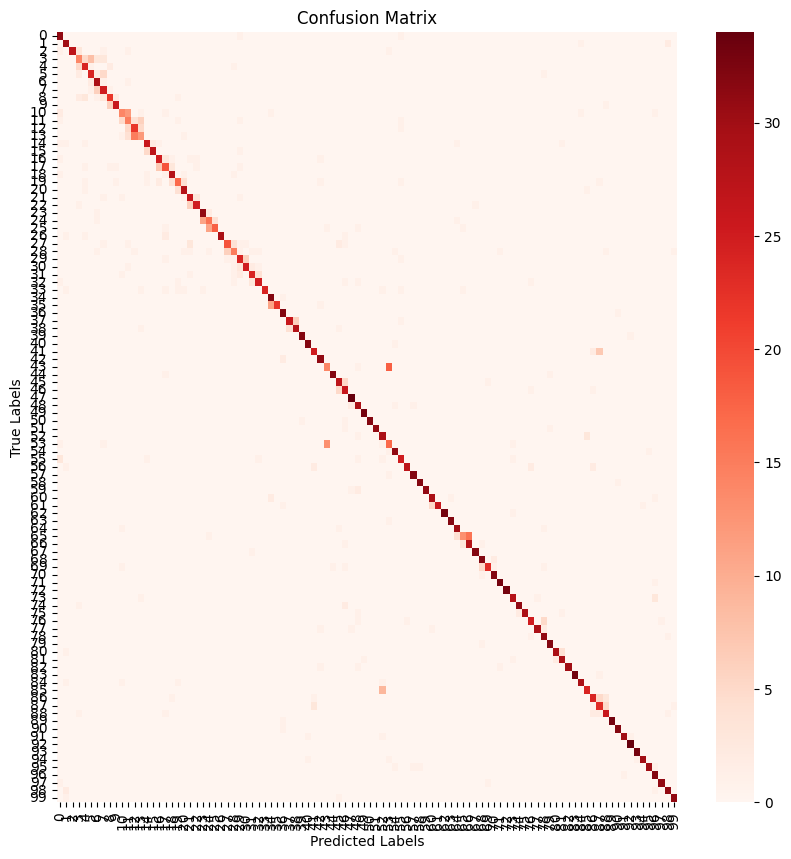

In [21]:
import seaborn as sns

cm = confusion_matrix(test['Labels'],pred.argmax(axis = 1))

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Reds", xticklabels=np.unique(test['Labels']),
            yticklabels=np.unique(pred.argmax(axis = 1)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Overall, the f1 scores for each class is decent enough and near to 1.0. However, for classes 13,24,28,43,53 and 65, the F1 score is quite poor. Near 0.5 F1 score indicates a bias towards either precision or recall. What this truly means is that for these classes, either we have too many false positives or false negatives. Both of these situations can affect the overall accuracy. To further improve the accuracy different augmentation techniques would be helpful. Also, a more complex architecture might help.

## Demo


In [9]:
model.load_weights("./model_weights_airplane/image_512_model.h5")
batch_size = 8
from sklearn.metrics import classification_report, confusion_matrix
AUTO = tf.data.experimental.AUTOTUNE
demo = pd.read_csv("./Classification/aircraft_img/aircraft_label.csv")
dpath = "./Classification/aircraft_img/"

demo_paths = demo.filename.apply(lambda x: os.path.join(dpath, x))
demo_labels = to_categorical(demo.Labels)

demo_dataset = (tf.data.Dataset.from_tensor_slices(demo_paths).map(decode_image, num_parallel_calls=AUTO).batch(batch_size))


pred_demo = model.predict(demo_dataset)
demo['Prediction'] = pred_demo.argmax(axis=1)
demo['Score'] = demo.apply(lambda x: check(x['Prediction'], x['Labels']), axis=1)
print('Demo accuracy on iterations is ', 100 * demo.Score.sum() / demo.shape[0])


print(classification_report(demo.Labels, demo.Prediction))

AttributeError: 'DataFrame' object has no attribute 'filename'

In [ ]:
import seaborn as sns

cm = confusion_matrix(demo['Labels'],pred_demo.argmax(axis = 1))

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Reds", xticklabels=np.unique(demo['Labels']),
            yticklabels=np.unique(pred_demo.argmax(axis = 1)))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

16/16 [==============================] - 0s 24ms/step
2033    DHC-8-300
Name: Classes, dtype: object


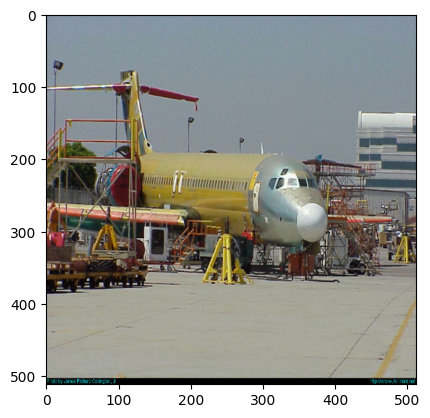

In [46]:
# demo_image = tf.io.read_file("./0038671.jpg")

demo_image = decode_image("./0038671.jpg")

pred = model.predict(demo_image)
val = np.unique(pred.argmax(axis = 1))
# Retrieve the corresponding class using boolean indexing
# predicted_class = test.loc[test['Labels'] == np.unique(pred.argmax(axis = 1)), 'Classes'].values[0]
predicted_class = test[test['Labels'] == val[0]].head(1)

print(predicted_class['Classes'])
plt.imshow(demo_image)